Proof of principle convolutional network in Keras for categorical classification of MNIST handwritten digits dataset

In [1]:
%matplotlib inline

In [2]:
# module imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

In [3]:
# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# print some shapes
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
# number of classes
num_classes = np.unique(y_train).size

In [6]:
# divide MNIST test set into validation and test sets of equal size.
x_val = x_test[:5000]
y_val = y_test[:5000]
x_test = x_test[5000:]
y_test = y_test[5000:]

In [7]:
# add an empty dimension to the last axis (in principle one could have RGB values)
x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)
x_test = np.expand_dims(x_test, -1)

In [8]:
# Convert class vectors to categorical
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

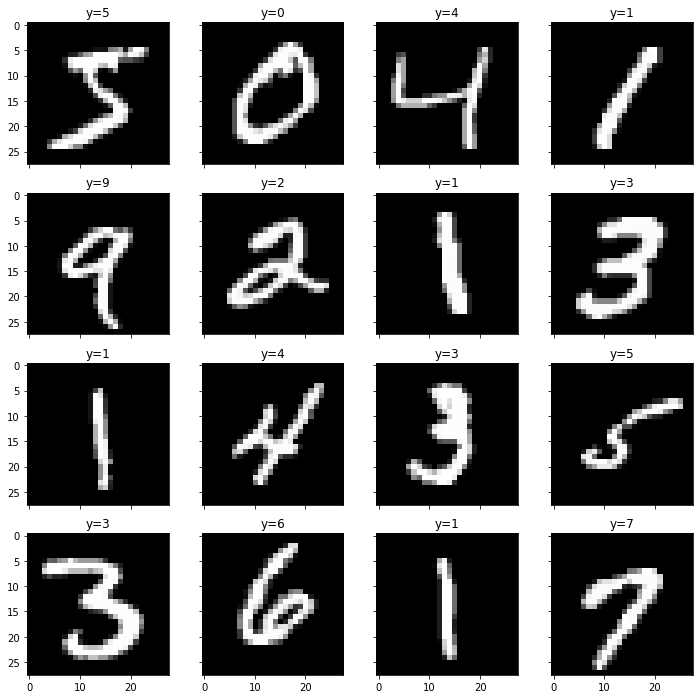

In [9]:
# plot data and labels
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12, 12))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_train[i, :, :, 0], vmin=0, vmax=255, cmap='gray')
    ax.set_title('y={}'.format(np.where(y_train[i]==1.)[0][0]))

In [10]:
def define_model(input_shape, num_classes, lr=0.001, dr=0.25,
                 clear_session=True):
    if clear_session:
        keras.backend.clear_session()

    # define model
    model = keras.models.Sequential()

    # conv layer 1
    model.add(keras.layers.Conv2D(16, (3, 3), 
                                  padding='same', 
                                  input_shape=input_shape,
                                  activation='relu'))

    # conv layer 2 + pooling
    model.add(keras.layers.Conv2D(32, (3, 3), 
                                  strides=(2, 2), 
                                  activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(dr))

    # conv layer 3 + pooling
    model.add(keras.layers.Conv2D(64, (3, 3), 
                                  strides=(2, 2), 
                                  activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(dr))

    # flatten
    model.add(keras.layers.Flatten())

    # dense layer 1
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(dr))

    # dense output layer with softmax activation
    model.add(keras.layers.Dense(num_classes, 
                                 activation='softmax'))

    # optimizer
    opt = keras.optimizers.Adam(lr=lr)

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # return model
    return model

In [11]:
model = define_model(input_shape=x_train.shape[1:], num_classes=num_classes)

# print out info
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 64)          0

In [12]:
# fit data
history = model.fit(x_train, y_train, batch_size=100, epochs=10, 
                   validation_data=(x_val, y_val))

Train on 60000 samples, validate on 5000 samples
Epoch 1/10
60000/60000 [==============================] - 25s 413us/sample - loss: 1.5784 - accuracy: 0.5625 - val_loss: 0.3114 - val_accuracy: 0.9090
Epoch 2/10
60000/60000 [==============================] - 24s 402us/sample - loss: 0.4241 - accuracy: 0.8727 - val_loss: 0.1867 - val_accuracy: 0.9458
Epoch 3/10
60000/60000 [==============================] - 22s 360us/sample - loss: 0.2924 - accuracy: 0.9135 - val_loss: 0.1458 - val_accuracy: 0.9532
Epoch 4/10
60000/60000 [==============================] - 24s 403us/sample - loss: 0.2399 - accuracy: 0.9292 - val_loss: 0.1248 - val_accuracy: 0.9632
Epoch 5/10
60000/60000 [==============================] - 24s 394us/sample - loss: 0.2060 - accuracy: 0.9391 - val_loss: 0.0998 - val_accuracy: 0.9698
Epoch 6/10
60000/60000 [==============================] - 23s 376us/sample - loss: 0.1814 - accuracy: 0.9463 - val_loss: 0.0999 - val_accuracy: 0.9672
Epoch 7/10
60000/60000 [=====================

Text(0.5, 0, 'epochs')

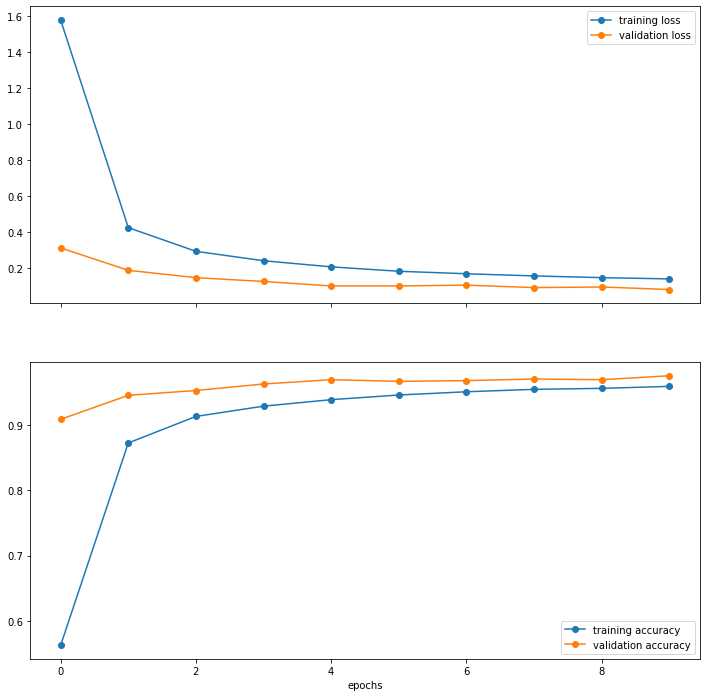

In [13]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 12))
axes[0].plot(history.history['loss'], '-o', label='training loss')
axes[0].plot(history.history['val_loss'], '-o', label='validation loss')
axes[0].legend()
axes[1].plot(history.history['accuracy'], '-o', label='training accuracy')
axes[1].plot(history.history['val_accuracy'], '-o', label='validation accuracy')
axes[1].legend()
axes[1].set_xlabel('epochs')

In [14]:
# run predictions on some test samples
y_pred = model.predict(x_test.astype(float))
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.03568696122330148
Test accuracy: 0.9906


Text(0, 0.5, 'true labels')

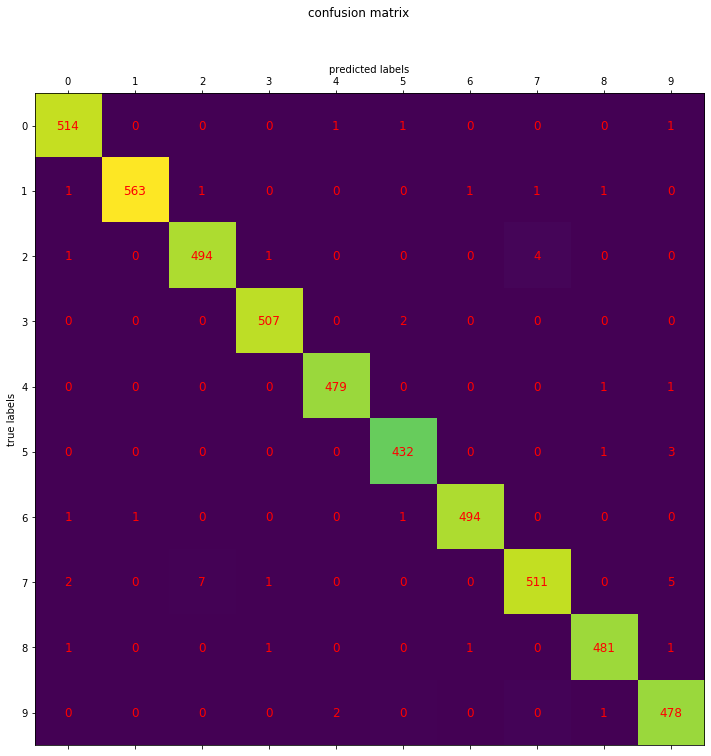

In [15]:
# compute and plot confusion matrix
cf = tf.math.confusion_matrix(np.where(y_test == 1)[1], 
                              np.argmax(y_pred, axis=-1), 
                              num_classes=num_classes)
cf = np.array(cf)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
fig.suptitle('confusion matrix')
im = ax.matshow(cf)
ax.axis(ax.axis('tight'))
# cb = plt.colorbar(im)
# cb.set_label('#')
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(i, j, cf[i, j], fontsize=12, color='r', ha='center', va='center')

ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xlabel('predicted labels')
ax.xaxis.set_label_position('top')
ax.set_ylabel('true labels')

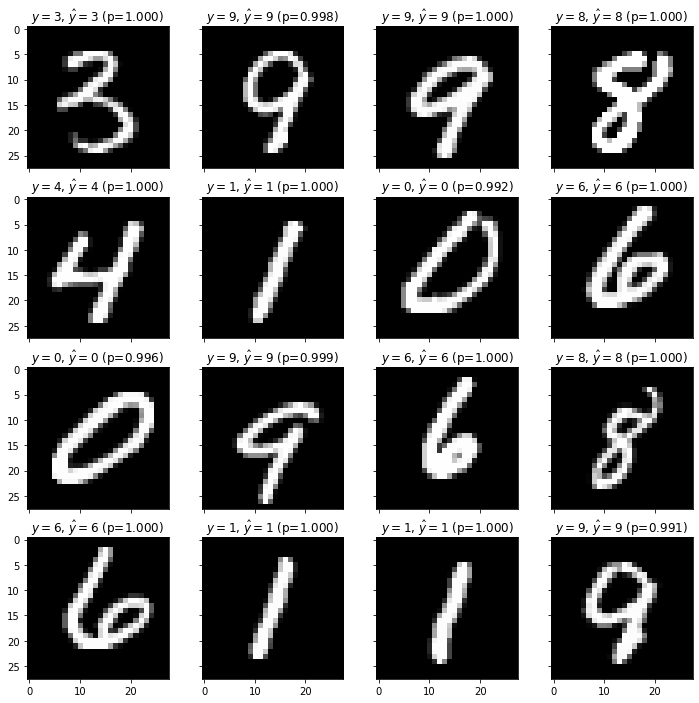

In [16]:
# plot actual vs. predicted labels and their probabilities
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12, 12))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_test[i, :, :, 0], vmin=0, vmax=255, cmap='gray')
    ax.set_title('$y=${}, '.format(np.where(y_test[i]==1.)[0][0]) +
                 '$\hat{y}=$' + '{} (p={:.3f})'.format(np.where(y_pred[i]==y_pred[i].max())[0][0], 
                                                       y_pred[i].max()))